In [1]:
import os
import sys
from dask.distributed import Client
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json', threads_per_worker=2, n_workers=6)
client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler.json')  
# client = Client(scheduler_file='/proj/kimyy/Dropbox/source/python/all/mpi/scheduler_10.json')  

# add private module path for workers
# client.run(lambda: os.environ.update({'PYTHONPATH': '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'}))
# def add_path():
#     if '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2' not in sys.path:
#         sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')

# client.run(add_path)

def setup_module_path():
    module_path = '/proj/kimyy/Dropbox/source/python/all/Modules/CESM2'
    if module_path not in sys.path:
        sys.path.append(module_path)

client.run(setup_module_path)

client

<Client: 'tcp://203.247.189.224:44013' processes=5 threads=90, memory=419.10 GiB>

# Load modules

In [2]:
# load public modules

import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats
import cmocean
from cmcrameri import cm
import warnings
warnings.simplefilter(action='ignore')
import pandas as pd
import cftime
import pop_tools
from pprint import pprint
import time
import subprocess
import re as re_mod
import cftime
import datetime
from scipy.stats import ttest_1samp
import xcesm

In [3]:
# load private modules

import sys
sys.path.append('/proj/kimyy/Dropbox/source/python/all/Modules/CESM2')
from KYY_CESM2_preprocessing import CESM2_config
# import KYY_CESM2_preprocessing
# import importlib
# importlib.reload(KYY_CESM2_preprocessing)

# Variable configuration

In [4]:
ds_grid = pop_tools.get_grid('POP_gx1v7')

cfg_var_TEMP=CESM2_config()
cfg_var_TEMP.year_s=1850
cfg_var_TEMP.year_e=2024
cfg_var_TEMP.setvar('TEMP')

In [5]:
cut_grid_info = {
    "lonw": 210,
    "lone": 270,
    "lats": -20,
    "latn": 10
}

# Read files

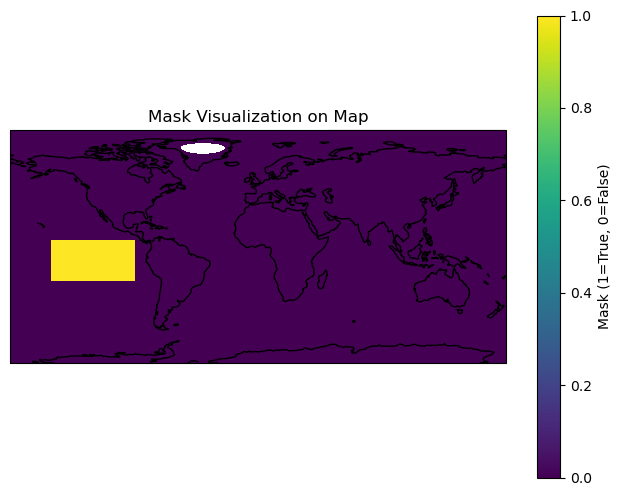

In [6]:
ds=ds_grid
mask = ((ds.TLONG >= cut_grid_info["lonw"]) 
        & (ds.TLONG <= cut_grid_info["lone"]) 
        & (ds.TLAT >= cut_grid_info["lats"]) 
        & (ds.TLAT <= cut_grid_info["latn"]))
iy, ix = np.where(mask)

fig, ax = plt.subplots(subplot_kw={'projection': ccrs.PlateCarree()}, figsize=(8, 6))

# mask를 1/0으로 변환한 뒤 지도 위에 겹쳐서 표시
pc = ax.pcolormesh(ds.TLONG, ds.TLAT, mask.astype(int),
                   transform=ccrs.PlateCarree(),
                   cmap='viridis')

ax.coastlines()
plt.colorbar(pc, ax=ax, label='Mask (1=True, 0=False)')
plt.title('Mask Visualization on Map')
plt.show()

In [7]:
# define preprocessing function

ds_grid_sub = ds_grid.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_avg_manual = xr.Dataset()

# data = cfg_var_NO3.LE_ds['NO3']
# weighted_sum = (data * area).sum(dim=['nlat','nlon'], skipna=True)
# effective_area = area.where(data.notnull()).sum(dim=['nlat','nlon'], skipna=True)
# weighted_avg_manual['NO3'] = weighted_sum / effective_area



exceptcv=['time','lon','lat','lev', 'TLONG', 'TLAT', 'z_w', cfg_var_TEMP.var]

def process_coords(varname, mask, ds_grid_sub, ds, sd, ed, drop=True, except_coord_vars=exceptcv):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    ds= ds.isel(z_t=slice(0, 1))
    ds= ds.isel(z_w=slice(0, 1))
   
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    
    
    if drop:
        ds= ds.drop(coord_vars)
        ds= ds.sel(time=slice(sd, ed))
        return ds
    else:
        return ds.set_coords(coord_vars)


def process_coords_obs(ds, drop=True, except_coord_vars=['time','valid_time', 'lon','lat', 'TLONG', 'TLAT', 'sst', 'PP', 'sla', 'SOMXL030', 'NAV_LON', 'NAV_LAT', 'u10', 'v10']):
    """Preprocessor function to drop all non-dim coords, which slows down concatenation."""
    coord_vars = []
    for v in np.array(ds.coords) :
        if not v in except_coord_vars:
            coord_vars += [v]
    for v in np.array(ds.data_vars) :
        if not v in except_coord_vars:
            coord_vars += [v]

    # ds = ds.where(mask, drop=True)
    # volume= ds_grid_sub['dz'] * ds_grid_sub['TAREA']
    # weighted_sum = (ds[varname] * volume).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # effective_volume = volume.where(ds[varname].notnull()).sum(dim=['nlat','nlon','z_t'], skipna=True)
    # ds[varname] = weighted_sum / effective_volume
    if 'valid_time' in ds:
        ds = ds.rename({'valid_time': 'time'})
    
    if drop:
        ds= ds.drop(coord_vars)
        return ds
    else:
        return ds.set_coords(coord_vars)

start_date = cftime.DatetimeNoLeap(cfg_var_TEMP.year_s, 2, 1)
end_date = cftime.DatetimeNoLeap(cfg_var_TEMP.year_e+1, 1, 1)

In [8]:
# Read LE dataset

start_time = time.time()

# TEMP
dname=cfg_var_TEMP.var
cfg_var_TEMP.LE_path_load(cfg_var_TEMP.var)
cfg_var_TEMP.LE_ds = xr.open_mfdataset(cfg_var_TEMP.LE_file_list[0], 
                       chunks={'time': 12}, 
                       combine='nested', 
                       concat_dim=[[*cfg_var_TEMP.LE_ensembles], 'time'], 
                       parallel=True,
                       preprocess=lambda ds: process_coords(dname, mask, ds_grid_sub, ds, cftime.DatetimeNoLeap(1998, 2, 1), cftime.DatetimeNoLeap(2023, 1, 1)),
                       decode_cf=True, 
                       decode_times=True)      

cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.rename({"concat_dim": "ens_LE"})
new_time = cfg_var_TEMP.LE_ds.time - np.array([datetime.timedelta(days=15)] * len(cfg_var_TEMP.LE_ds.time))
cfg_var_TEMP.LE_ds = cfg_var_TEMP.LE_ds.assign_coords(time=new_time)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading LE: ' + str(elapsed_time))

elasped time for reading LE: 258.58173084259033


In [9]:
start_time = time.time()

filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

LE_data = xr.open_dataset(filename)

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for writing netcdf: ' + str(elapsed_time))

elasped time for writing netcdf: 0.16295623779296875


In [10]:
# Read Observation dataset (TEMP)
start_time = time.time()

# TEMP
cfg_var_TEMP.OBS_path_load(cfg_var_TEMP.var)
dname=cfg_var_TEMP.OBS_var
cfg_var_TEMP.OBS_ds = xr.open_mfdataset(
    cfg_var_TEMP.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.rename({cfg_var_TEMP.OBS_var: cfg_var_TEMP.var})
cfg_var_TEMP.OBS_ds.time

# global mean removal for SSH
if cfg_var_TEMP.var=='SSH':
    lat_mask = (ds_grid.TLAT >= -60) & (ds_grid.TLAT <= 60)

    area_selected = ds_grid.TAREA.where(lat_mask, drop=True)  # 선택된 지역의 면적
    ssh_selected = cfg_var_TEMP.OBS_ds[cfg_var_TEMP.var].where(lat_mask, drop=True)  # 선택된 지역의 SSH 데이터

    cfg_var_TEMP.OBS_ds['gm'] = (ssh_selected * area_selected).sum(dim=['nlat', 'nlon']) / area_selected.sum(dim=['nlat', 'nlon'])
    cfg_var_TEMP.OBS_ds['SSH'] = cfg_var_TEMP.OBS_ds[cfg_var_TEMP.var] - cfg_var_TEMP.OBS_ds['gm']


cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.where(mask, drop=True)
area = ds_grid_sub['TAREA']
weighted_sum = (cfg_var_TEMP.OBS_ds['TEMP'] * area).sum(dim=['nlat','nlon'], skipna=True)
effective_area = area.where(cfg_var_TEMP.OBS_ds['TEMP'].notnull()).sum(dim=['nlat','nlon'], skipna=True)
cfg_var_TEMP.OBS_ds['TEMP'] = weighted_sum / effective_area

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

elasped time for reading OBS: 154.57909035682678


In [11]:
# data_read

SST_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_TEMP_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_SST = xr.open_dataset(SST_filename)

    
SSH_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_SSH_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_SSH = xr.open_dataset(SSH_filename)

NPP_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_photoC_TOT_zint_100m_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_NPP = xr.open_dataset(NPP_filename)

HBLT_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_HBLT_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_HBLT = xr.open_dataset(HBLT_filename)
data_HBLT = data_HBLT.rename({'time_counter': 'time'})

U010_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_U010_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_U010 = xr.open_dataset(U010_filename)

V010_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_obs_V010_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)

data_V010 = xr.open_dataset(V010_filename)




In [12]:
LE_filename = (
    "/mnt/lustre/proj/kimyy/Model/CESM2/ESP/for_LIM/LIM_input_LE_" 
    + "x1_" + str(cut_grid_info["lonw"])
    + "_x2_" + str(cut_grid_info["lone"])
    + "_y1_" + str(cut_grid_info["lats"])
    + "_y2_" + str(cut_grid_info["latn"])
    + ".nc"
)
data_LE = xr.open_dataset(LE_filename)

In [13]:
data_LE

<xarray.Dataset> Size: 7MB
Dimensions:               (ens_LE: 50, time: 2100)
Coordinates:
  * ens_LE                (ens_LE) int64 400B 0 1 2 3 4 5 ... 44 45 46 47 48 49
  * time                  (time) object 17kB 1850-01-17 00:00:00 ... 2024-12-...
Data variables:
    TEMP                  (ens_LE, time) float64 840kB ...
    photoC_TOT_zint_100m  (ens_LE, time) float64 840kB ...
    SSH                   (ens_LE, time) float64 840kB ...
    TAUX                  (ens_LE, time) float64 840kB ...
    TAUY                  (ens_LE, time) float64 840kB ...
    NO3                   (ens_LE, time) float64 840kB ...
    Fe                    (ens_LE, time) float64 840kB ...
    HBLT                  (ens_LE, time) float64 840kB ...

In [14]:
# data_HBLT = data_HBLT.rename({'time_counter': 'time'})

ValueError: cannot rename 'time_counter' because it is not a variable or dimension in this dataset

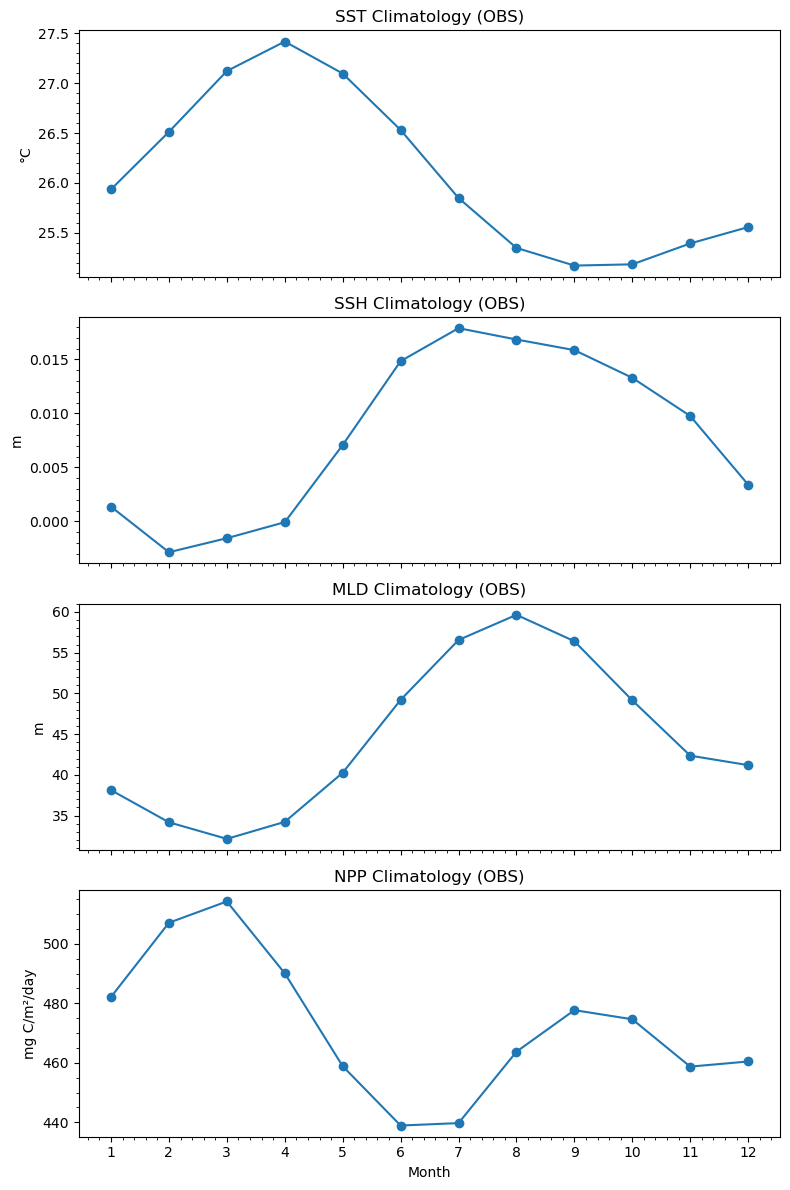

In [16]:


data_subset = data_SST.sel(time=slice("1998-01-01", "2023-12-31"))
SST_mon_clim = data_subset.groupby("time.month").mean(dim="time")

data_subset = data_SSH.sel(time=slice("1998-01-01", "2023-12-31"))
SSH_mon_clim = data_subset.groupby("time.month").mean(dim="time")

data_subset = data_NPP.sel(time=slice("1998-01-01", "2023-12-31"))
NPP_mon_clim = data_subset.groupby("time.month").mean(dim="time")

data_subset = data_HBLT.sel(time=slice("1998-01-01", "2023-12-31"))
HBLT_mon_clim = data_subset.groupby("time.month").mean(dim="time")

# x축: 월
months = np.arange(1, 13)

# Figure 생성
fig, axs = plt.subplots(4, 1, figsize=(8, 12), sharex=True)

# 각 subplot에 변수별 climatology 그리기
axs[0].plot(months, SST_mon_clim['obs_SST'], marker='o')
axs[0].set_title("SST Climatology (OBS)")
axs[0].set_ylabel("°C")

axs[1].plot(months, SSH_mon_clim['obs_SSH'], marker='o')
axs[1].set_title("SSH Climatology (OBS)")
axs[1].set_ylabel("m")

axs[2].plot(months, HBLT_mon_clim['obs_HBLT'], marker='o')
axs[2].set_title("MLD Climatology (OBS)")
axs[2].set_ylabel("m")

axs[3].plot(months, NPP_mon_clim['obs_photoC_TOT_zint_100m'], marker='o')
axs[3].set_title("NPP Climatology (OBS)")
axs[3].set_ylabel("mg C/m²/day")
axs[3].set_xlabel("Month")

# x축 눈금 설정
for ax in axs:
    ax.set_xticks(months)
    ax.minorticks_on()                     # 소수 단위 눈금 표시
    # ax.grid(which='major', linestyle='-', linewidth=0.8)   # 주격자선
    # ax.grid(which='minor', linestyle=':', linewidth=0.5)   # 소격자선

    

plt.tight_layout()
plt.show()

In [17]:
# Read Observation dataset (TEMP)
start_time = time.time()

# TEMP
cfg_var_TEMP.OBS_path_load(cfg_var_TEMP.var)
dname=cfg_var_TEMP.OBS_var
cfg_var_TEMP.OBS_ds = xr.open_mfdataset(
    cfg_var_TEMP.OBS_file_list[0][0],
    chunks={'time': 12},
    parallel=True,
    preprocess=lambda ds: process_coords_obs(ds),
    combine="by_coords",
    decode_times=True,  # skip calendar/time decoding
)

cfg_var_TEMP.OBS_ds = cfg_var_TEMP.OBS_ds.rename({cfg_var_TEMP.OBS_var: cfg_var_TEMP.var})

end_time = time.time()
elapsed_time = end_time - start_time
print('elasped time for reading OBS: ' + str(elapsed_time))

elasped time for reading OBS: 152.18321180343628


In [18]:
nino_mask  = ((ds.TLONG >= 190) 
        & (ds.TLONG <= 240) 
        & (ds.TLAT >= -5) 
        & (ds.TLAT <= 5))

NINO34 = cfg_var_TEMP.OBS_ds.where(nino_mask, drop=True)

ds_grid_nino = ds_grid.where(nino_mask, drop=True)
area_nino = ds_grid_nino['TAREA']
weighted_sum = (NINO34['TEMP'] * area_nino).sum(dim=['nlat','nlon'], skipna=True)
effective_area = area_nino.where(NINO34['TEMP'].notnull()).sum(dim=['nlat','nlon'], skipna=True)
nino34_f = weighted_sum / effective_area


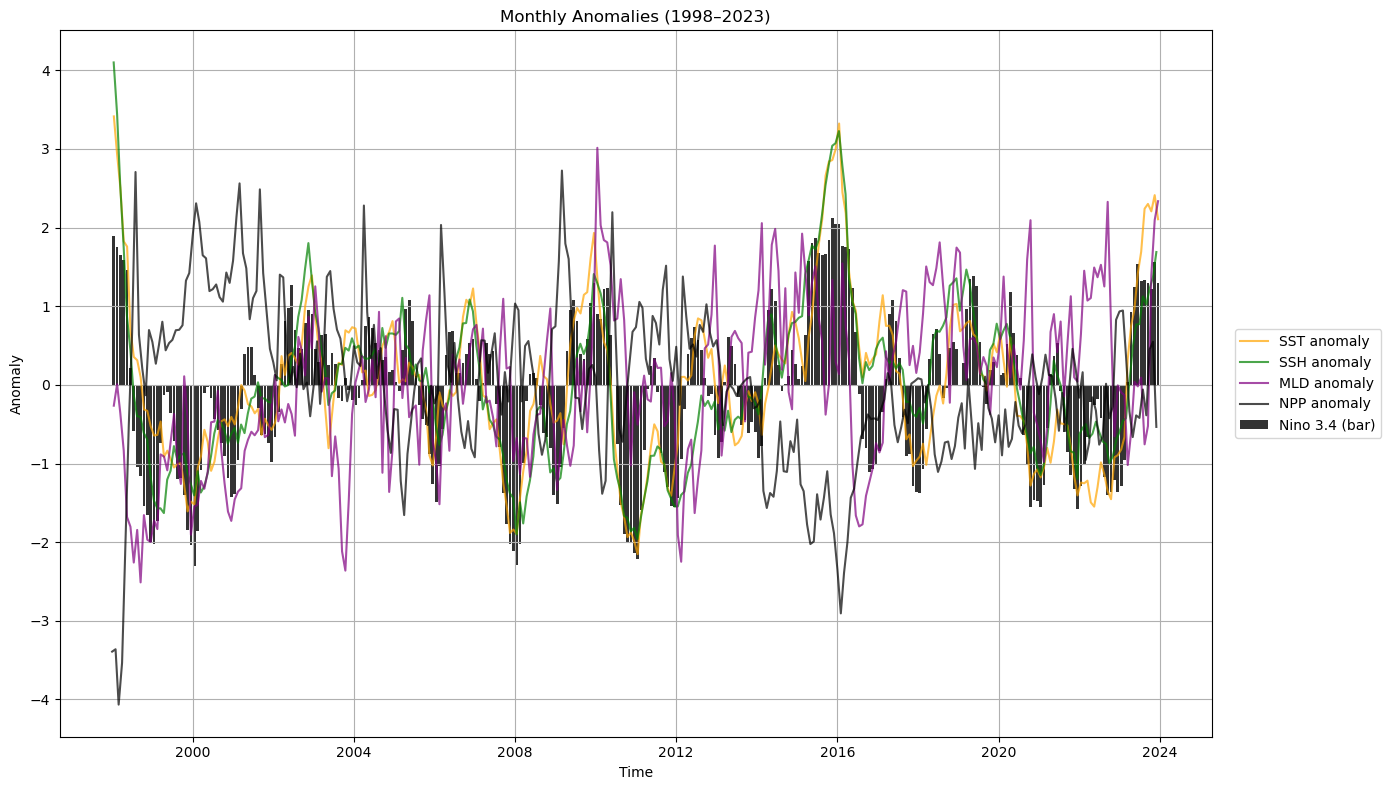

In [19]:
data_subset = data_SST.sel(time=slice("1998-01-01", "2023-12-31"))
SST_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SST_anom = data_subset.groupby("time.month") - SST_mon_clim
SST_anom = SST_anom / SST_anom.std()

data_subset = data_SSH.sel(time=slice("1998-01-01", "2023-12-31"))
SSH_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SSH_anom = data_subset.groupby("time.month") - SSH_mon_clim
SSH_anom = SSH_anom / SSH_anom.std()

data_subset = data_NPP.sel(time=slice("1998-01-01", "2023-12-31"))
NPP_mon_clim = data_subset.groupby("time.month").mean(dim="time")
NPP_anom = data_subset.groupby("time.month") - NPP_mon_clim
NPP_anom = NPP_anom / NPP_anom.std()

data_subset = data_HBLT.sel(time=slice("1998-01-01", "2023-12-31"))
HBLT_mon_clim = data_subset.groupby("time.month").mean(dim="time")
HBLT_anom = data_subset.groupby("time.month") - HBLT_mon_clim
HBLT_anom = HBLT_anom / HBLT_anom.std()

nino_anom = nino34_f.sel(time=slice("1998-01-01", "2023-12-31"))
nino_anom = nino_anom - nino34_f.sel(time=slice("1980-01-01", "2020-12-31")).mean(dim='time')


fig, ax = plt.subplots(figsize=(14, 8))  # 세로축 길이 증가

# 1. 선 그래프들 먼저
SST_anom['obs_SST'].plot(ax=ax, label='SST anomaly', color='orange', alpha=0.7)
SSH_anom['obs_SSH'].plot(ax=ax, label='SSH anomaly', color='green', alpha=0.7)
HBLT_anom['obs_HBLT'].plot(ax=ax, label='MLD anomaly', color='purple', alpha=0.7)
NPP_anom['obs_photoC_TOT_zint_100m'].plot(ax=ax, label='NPP anomaly', color='black', alpha=0.7)

# 2. nino_anom: bar plot
ax.bar(nino_anom['time'].values,
       nino_anom.values,
       width=np.timedelta64(25, 'D'), 
       label='Nino 3.4 (bar)',
       color='black',
       alpha=0.8)

# 제목, 라벨, 그리드
ax.set_title("Monthly Anomalies (1998–2023)")
ax.set_ylabel("Anomaly")
ax.grid(True)

# legend 바깥
ax.legend(loc='center left', bbox_to_anchor=(1.02, 0.5), borderaxespad=0.)

plt.tight_layout()
plt.show()

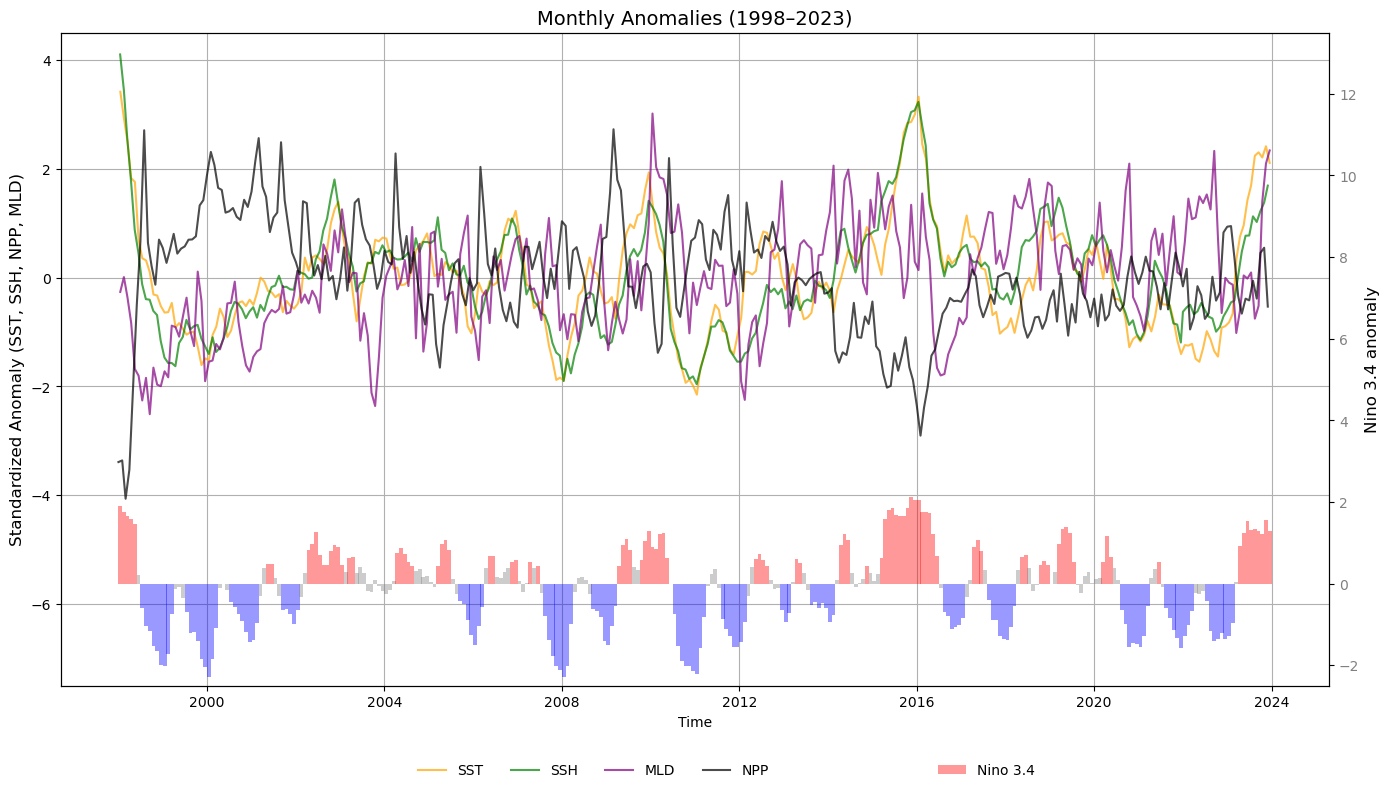

In [20]:
data_subset = data_SST.sel(time=slice("1998-01-01", "2023-12-31"))
SST_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SST_anom = data_subset.groupby("time.month") - SST_mon_clim
SST_anom = SST_anom / SST_anom.std()

data_subset = data_SSH.sel(time=slice("1998-01-01", "2023-12-31"))
SSH_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SSH_anom = data_subset.groupby("time.month") - SSH_mon_clim
SSH_anom = SSH_anom / SSH_anom.std()

data_subset = data_NPP.sel(time=slice("1998-01-01", "2023-12-31"))
NPP_mon_clim = data_subset.groupby("time.month").mean(dim="time")
NPP_anom = data_subset.groupby("time.month") - NPP_mon_clim
NPP_anom = NPP_anom / NPP_anom.std()

data_subset = data_HBLT.sel(time=slice("1998-01-01", "2023-12-31"))
HBLT_mon_clim = data_subset.groupby("time.month").mean(dim="time")
HBLT_anom = data_subset.groupby("time.month") - HBLT_mon_clim
HBLT_anom = HBLT_anom / HBLT_anom.std()

nino_anom = nino34_f.sel(time=slice("1998-01-01", "2023-12-31"))
nino_anom = nino_anom - nino34_f.sel(time=slice("1980-01-01", "2020-12-31")).mean(dim='time')


fig, ax = plt.subplots(figsize=(14, 8))  # 기본 subplot

# ---------- (1) 선 그래프 ---------- #
SST_anom['obs_SST'].plot(ax=ax, label='SST', color='orange', alpha=0.7)
SSH_anom['obs_SSH'].plot(ax=ax, label='SSH', color='green', alpha=0.7)
HBLT_anom['obs_HBLT'].plot(ax=ax, label='MLD', color='purple', alpha=0.7)
NPP_anom['obs_photoC_TOT_zint_100m'].plot(ax=ax, label='NPP', color='black', alpha=0.7)

# ---------- (2) Secondary axis: Nino bar ---------- #
ax2 = ax.twinx()  # 새로운 y축 (공통 x축)

# 바 색상: 양수 → red, 음수 → blue
bar_colors = ['red' if val > 0 else 'blue' for val in nino_anom.values]

bar_colors = [
    'red'   if val >= 0.4 else
    'blue'  if val <= -0.4 else
    'gray'
    for val in nino_anom.values
]

# bar plot
ax2.bar(nino_anom['time'].values,
        nino_anom.values,
        width=np.timedelta64(31, 'D'),
        color=bar_colors,
        alpha=0.4,
        label='Nino 3.4')

# ---------- (3) 스타일 및 레이블 ---------- #
ax.set_title("Monthly Anomalies (1998–2023)", fontsize=14)
ax.set_ylabel("Standardized Anomaly (SST, SSH, NPP, MLD)", fontsize=12)
ax.grid(True)
ax.set_ylim(-7.5, 4.5)

# 오른쪽 y축 라벨 지우기 또는 축 숨기기 (선택사항)
ax2.set_ylabel("Nino 3.4 anomaly", fontsize=12)
ax2.tick_params(axis='y', labelcolor='gray', labelsize=10)
ax2.set_ylim(-2.5, 13.5)

# ---------- (4) 범례 바깥으로 ---------- #
# 선 그래프용 범례만
# ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)
ax.legend(loc='upper center',         # 상단 중앙 기준으로
          bbox_to_anchor=(0.42, -0.10), # x=중앙, y=축 아래로
          ncol=5,                      # 항목들을 가로로 정렬 (최적 ncol 설정)
          frameon=False)              # 박스 제거 (선택)
ax2.legend(loc='upper center',         # 상단 중앙 기준으로
          bbox_to_anchor=(0.73, -0.1), # x=중앙, y=축 아래로
          ncol=1,                      # 항목들을 가로로 정렬 (최적 ncol 설정)
          frameon=False)              # 박스 제거 (선택)

plt.tight_layout()
plt.show()

In [21]:
time_common = slice("1998-01-01", "2023-12-31")

HBLT_anom = HBLT_anom.assign_coords(time=NPP_anom['time'])
SST_anom = SST_anom.assign_coords(time=NPP_anom['time'])
SSH_anom = SSH_anom.assign_coords(time=NPP_anom['time'])
nino_anom = nino_anom.assign_coords(time=NPP_anom['time'])

OBS_corr_HBLT=xr.corr(NPP_anom['obs_photoC_TOT_zint_100m'], HBLT_anom['obs_HBLT']) 
OBS_corr_SST=xr.corr(NPP_anom['obs_photoC_TOT_zint_100m'], SST_anom['obs_SST']) 
OBS_corr_SSH=xr.corr(NPP_anom['obs_photoC_TOT_zint_100m'], SSH_anom['obs_SSH']) 
OBS_corr_nino=xr.corr(NPP_anom['obs_photoC_TOT_zint_100m'], nino_anom) 



print("NPP vs HBLT correlation:", OBS_corr_HBLT.values)
print("NPP vs SST correlation:", OBS_corr_SST.values)
print("NPP vs SSH correlation:", OBS_corr_SSH.values)
print("NPP vs nino34 correlation:", OBS_corr_nino.values)

NPP vs HBLT correlation: -0.3836024687135334
NPP vs SST correlation: -0.5154864085443673
NPP vs SSH correlation: -0.6507447986613821
NPP vs nino34 correlation: -0.4702270314082612


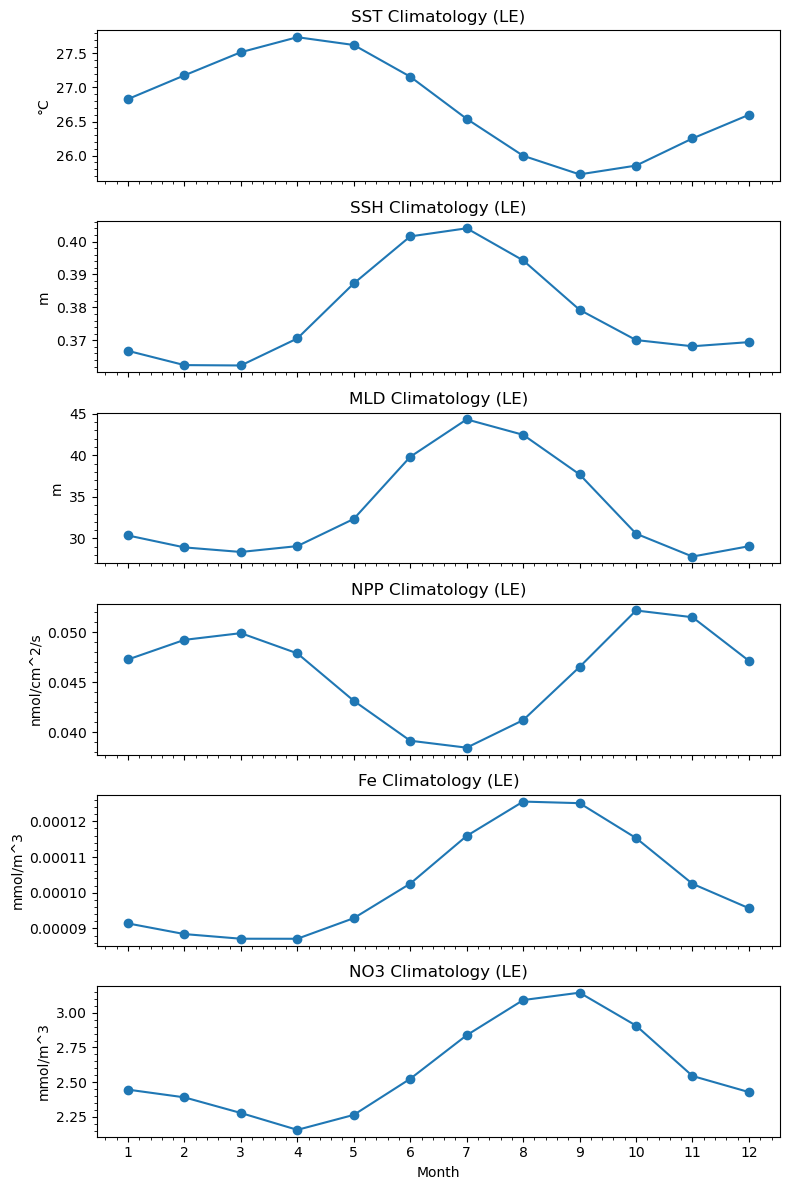

In [22]:


data_subset = data_LE.TEMP.sel(time=slice("1998-01-01", "2023-12-31"))
SST_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")

data_subset = data_LE.SSH.sel(time=slice("1998-01-01", "2023-12-31"))
SSH_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")/100

data_subset = data_LE.photoC_TOT_zint_100m.sel(time=slice("1998-01-01", "2023-12-31"))
NPP_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")

data_subset = data_LE.HBLT.sel(time=slice("1998-01-01", "2023-12-31"))
HBLT_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")/100

data_subset = data_LE.Fe.sel(time=slice("1998-01-01", "2023-12-31"))
Fe_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")

data_subset = data_LE.NO3.sel(time=slice("1998-01-01", "2023-12-31"))
NO3_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")


# x축: 월
months = np.arange(1, 13)

# Figure 생성
fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)

# 각 subplot에 변수별 climatology 그리기
axs[0].plot(months, SST_mon_clim, marker='o')
axs[0].set_title("SST Climatology (LE)")
axs[0].set_ylabel("°C")

axs[1].plot(months, SSH_mon_clim, marker='o')
axs[1].set_title("SSH Climatology (LE)")
axs[1].set_ylabel("m")

axs[2].plot(months, HBLT_mon_clim, marker='o')
axs[2].set_title("MLD Climatology (LE)")
axs[2].set_ylabel("m")

axs[3].plot(months, NPP_mon_clim, marker='o')
axs[3].set_title("NPP Climatology (LE)")
axs[3].set_ylabel("nmol/cm^2/s")

axs[4].plot(months, Fe_mon_clim, marker='o')
axs[4].set_title("Fe Climatology (LE)")
axs[4].set_ylabel("mmol/m^3")

axs[5].plot(months, NO3_mon_clim, marker='o')
axs[5].set_title("NO3 Climatology (LE)")
axs[5].set_ylabel("mmol/m^3")
axs[5].set_xlabel("Month")

# x축 눈금 설정
for ax in axs:
    ax.set_xticks(months)
    ax.minorticks_on()                     # 소수 단위 눈금 표시
    # ax.grid(which='major', linestyle='-', linewidth=0.8)   # 주격자선
    # ax.grid(which='minor', linestyle=':', linewidth=0.5)   # 소격자선

    

plt.tight_layout()
plt.show()

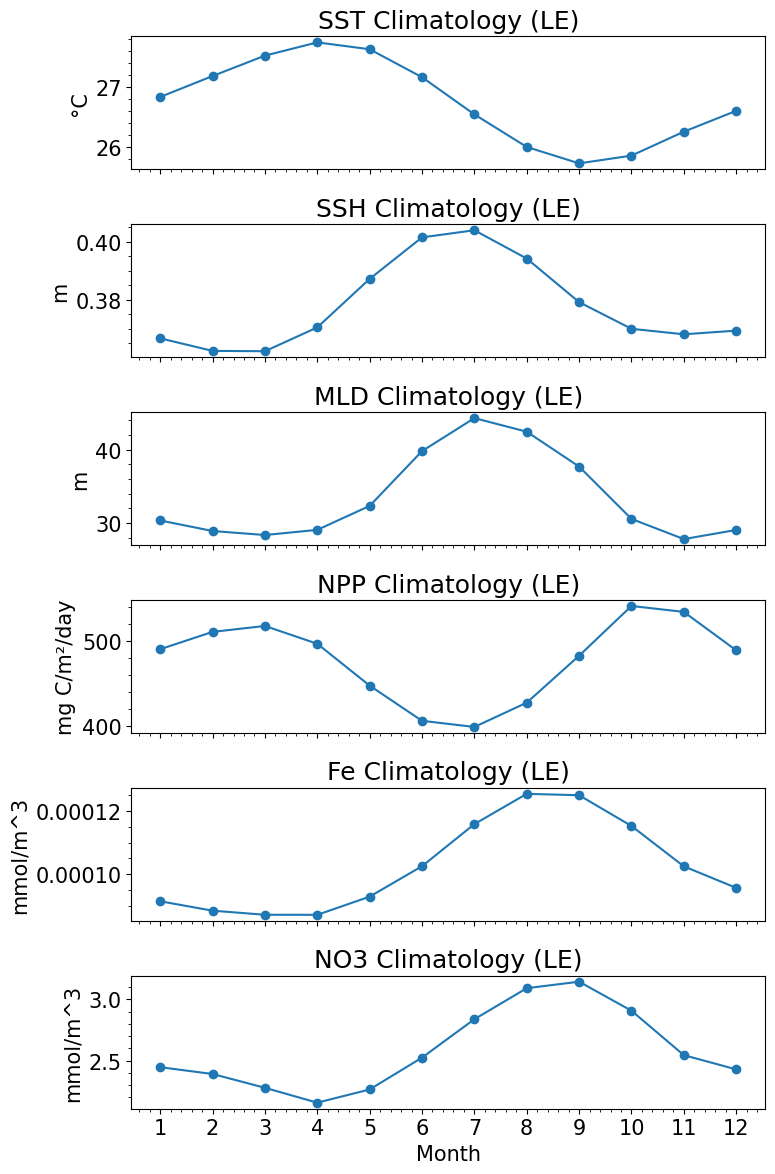

2025-07-08 15:04:30,609 - distributed.client - ERROR - Failed to reconnect to scheduler after 30.00 seconds, closing client


In [30]:


data_subset = data_LE.TEMP.sel(time=slice("1998-01-01", "2023-12-31"))
SST_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")

data_subset = data_LE.SSH.sel(time=slice("1998-01-01", "2023-12-31"))
SSH_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")/100

data_subset = data_LE.photoC_TOT_zint_100m.sel(time=slice("1998-01-01", "2023-12-31"))*10368
NPP_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")

data_subset = data_LE.HBLT.sel(time=slice("1998-01-01", "2023-12-31"))
HBLT_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")/100

data_subset = data_LE.Fe.sel(time=slice("1998-01-01", "2023-12-31"))
Fe_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")

data_subset = data_LE.NO3.sel(time=slice("1998-01-01", "2023-12-31"))
NO3_mon_clim = data_subset.groupby("time.month").mean(dim="time").mean(dim="ens_LE")


# x축: 월
months = np.arange(1, 13)

# Figure 생성
fig, axs = plt.subplots(6, 1, figsize=(8, 12), sharex=True)

# 각 subplot에 변수별 climatology 그리기
axs[0].plot(months, SST_mon_clim, marker='o')
axs[0].set_title("SST Climatology (LE)")
axs[0].set_ylabel("°C")

axs[1].plot(months, SSH_mon_clim, marker='o')
axs[1].set_title("SSH Climatology (LE)")
axs[1].set_ylabel("m")

axs[2].plot(months, HBLT_mon_clim, marker='o')
axs[2].set_title("MLD Climatology (LE)")
axs[2].set_ylabel("m")

axs[3].plot(months, NPP_mon_clim, marker='o')
axs[3].set_title("NPP Climatology (LE)")
# axs[3].set_ylabel("nmol/cm^2/s")
axs[3].set_ylabel("mg C/m²/day")

axs[4].plot(months, Fe_mon_clim, marker='o')
axs[4].set_title("Fe Climatology (LE)")
axs[4].set_ylabel("mmol/m^3")

axs[5].plot(months, NO3_mon_clim, marker='o')
axs[5].set_title("NO3 Climatology (LE)")
axs[5].set_ylabel("mmol/m^3")
axs[5].set_xlabel("Month")

# x축 눈금 설정
for ax in axs:
    ax.set_xticks(months)
    ax.minorticks_on()                     # 소수 단위 눈금 표시
    # ax.grid(which='major', linestyle='-', linewidth=0.8)   # 주격자선
    # ax.grid(which='minor', linestyle=':', linewidth=0.5)   # 소격자선

    

plt.tight_layout()
plt.show()

In [24]:
cfg_var_TEMP.LE_ds

NINO34_LE = cfg_var_TEMP.LE_ds.where(nino_mask, drop=True)

ds_grid_nino = ds_grid.where(nino_mask, drop=True)
area_nino = ds_grid_nino['TAREA']
weighted_sum = (NINO34_LE['TEMP'] * area_nino).sum(dim=['nlat','nlon'], skipna=True)
effective_area = area_nino.where(NINO34_LE['TEMP'].notnull()).sum(dim=['nlat','nlon'], skipna=True)
nino34_LE_f = weighted_sum / effective_area
nino34_LE_f = nino34_LE_f.isel(z_t=0)
nino34_LE_f.compute()

<xarray.DataArray (ens_LE: 50, time: 300)> Size: 120kB
array([[28.19038626, 28.28166567, 28.62444952, ..., 25.47734871,
        25.83467465, 25.81036894],
       [26.46551222, 26.78586966, 27.44023022, ..., 24.98002239,
        25.17755349, 25.40478975],
       [26.32656619, 27.01355265, 27.67423478, ..., 27.35922879,
        27.40505859, 27.72531743],
       ...,
       [25.32309162, 25.58712991, 26.25444542, ..., 26.30592197,
        26.42116286, 26.64343609],
       [27.5014708 , 27.9353571 , 28.47140502, ..., 27.38449343,
        27.76829963, 28.14197024],
       [30.66999619, 30.20342045, 29.09564378, ..., 27.66687727,
        28.05075843, 28.38624528]])
Coordinates:
  * ens_LE   (ens_LE) int64 400B 0 1 2 3 4 5 6 7 8 ... 42 43 44 45 46 47 48 49
  * time     (time) object 2kB 1998-01-17 00:00:00 ... 2022-12-17 00:00:00

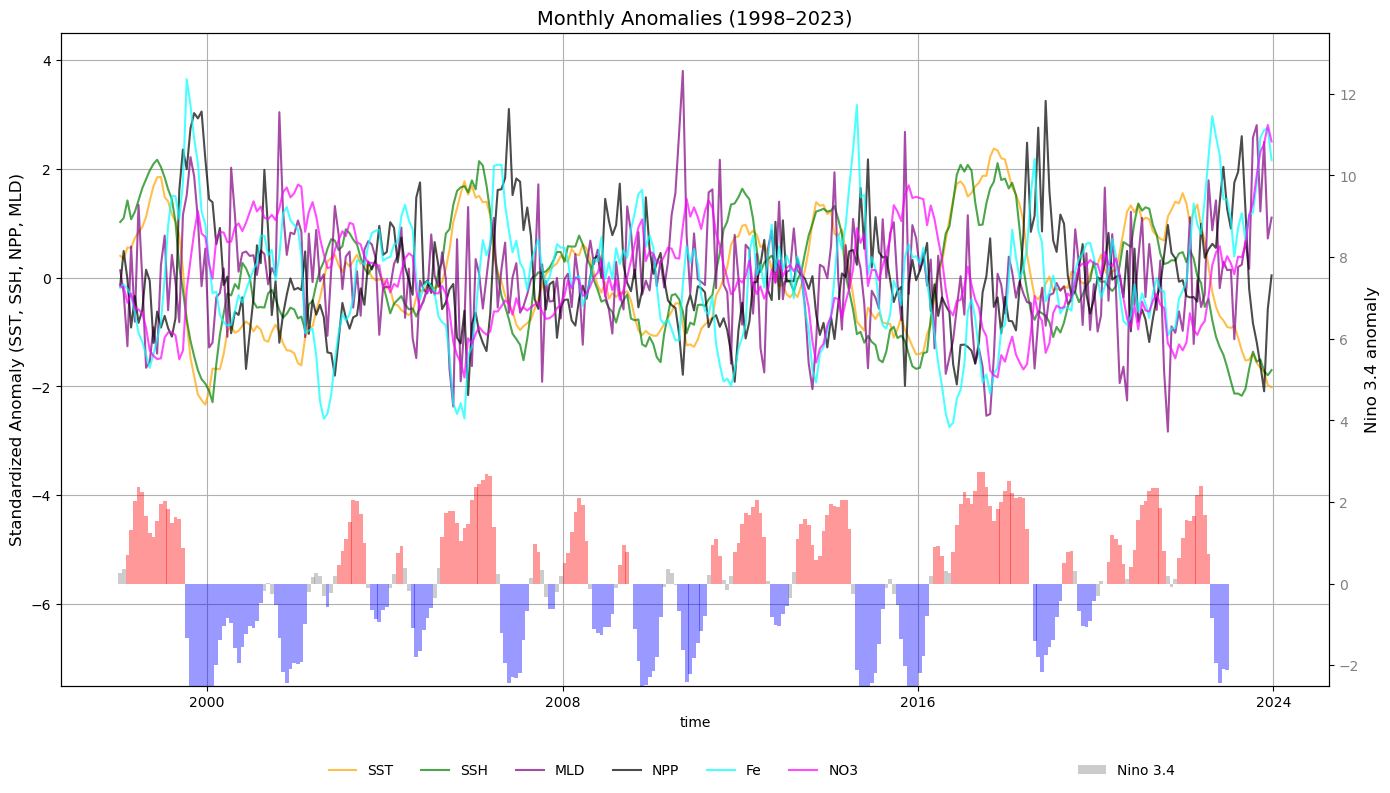

In [25]:
data_subset = data_LE.TEMP.sel(time=slice("1998-01-01", "2023-12-31"))
SST_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SST_anom = data_subset.groupby("time.month") - SST_mon_clim
SST_anom = SST_anom / SST_anom.std()
SST_anom= SST_anom.isel(ens_LE=0)

data_subset = data_LE.SSH.sel(time=slice("1998-01-01", "2023-12-31"))
SSH_mon_clim = data_subset.groupby("time.month").mean(dim="time")
SSH_anom = data_subset.groupby("time.month") - SSH_mon_clim
SSH_anom = SSH_anom / SSH_anom.std()
SSH_anom= SSH_anom.isel(ens_LE=0)

data_subset = data_LE.photoC_TOT_zint_100m.sel(time=slice("1998-01-01", "2023-12-31"))
NPP_mon_clim = data_subset.groupby("time.month").mean(dim="time").isel(ens_LE=0)
NPP_anom = data_subset.groupby("time.month") - NPP_mon_clim
NPP_anom = NPP_anom / NPP_anom.std()
NPP_anom= NPP_anom.isel(ens_LE=0)

data_subset = data_LE.HBLT.sel(time=slice("1998-01-01", "2023-12-31"))
HBLT_mon_clim = data_subset.groupby("time.month").mean(dim="time")
HBLT_anom = data_subset.groupby("time.month") - HBLT_mon_clim
HBLT_anom = HBLT_anom / HBLT_anom.std()
HBLT_anom= HBLT_anom.isel(ens_LE=0)

data_subset = data_LE.Fe.sel(time=slice("1998-01-01", "2023-12-31"))
Fe_mon_clim = data_subset.groupby("time.month").mean(dim="time")
Fe_anom = data_subset.groupby("time.month") - Fe_mon_clim
Fe_anom = Fe_anom / Fe_anom.std()
Fe_anom= Fe_anom.isel(ens_LE=0)

data_subset = data_LE.NO3.sel(time=slice("1998-01-01", "2023-12-31"))
NO3_mon_clim = data_subset.groupby("time.month").mean(dim="time")
NO3_anom = data_subset.groupby("time.month") - NO3_mon_clim
NO3_anom = NO3_anom / NO3_anom.std()
NO3_anom= NO3_anom.isel(ens_LE=0)

nino_anom = nino34_LE_f.sel(time=slice("1998-01-01", "2023-12-31")).isel(ens_LE=0)
nino_anom = nino_anom - nino34_LE_f.sel(time=slice("1980-01-01", "2020-12-31")).isel(ens_LE=0).mean(dim='time')

fig, ax = plt.subplots(figsize=(14, 8))  # 기본 subplot

# ---------- (1) 선 그래프 ---------- #
SST_anom.plot(ax=ax, label='SST', color='orange', alpha=0.7)
SSH_anom.plot(ax=ax, label='SSH', color='green', alpha=0.7)
HBLT_anom.plot(ax=ax, label='MLD', color='purple', alpha=0.7)
NPP_anom.plot(ax=ax, label='NPP', color='black', alpha=0.7)
Fe_anom.plot(ax=ax, label='Fe', color='cyan', alpha=0.7)
NO3_anom.plot(ax=ax, label='NO3', color='magenta', alpha=0.7)

# ---------- (2) Secondary axis: Nino bar ---------- #
ax2 = ax.twinx()  # 새로운 y축 (공통 x축)

# 바 색상: 양수 → red, 음수 → blue
bar_colors = [
    'red'   if val >= 0.4 else
    'blue'  if val <= -0.4 else
    'gray'
    for val in nino_anom.values
]

# # bar plot
ax2.bar(nino_anom['time'].values,
        nino_anom.values,
        width=np.timedelta64(31, 'D'),
        color=bar_colors,
        alpha=0.4,
        label='Nino 3.4')

# ---------- (3) 스타일 및 레이블 ---------- #
ax.set_title("Monthly Anomalies (1998–2023)", fontsize=14)
ax.set_ylabel("Standardized Anomaly (SST, SSH, NPP, MLD)", fontsize=12)
ax.grid(True)
ax.set_ylim(-7.5, 4.5)

# # 오른쪽 y축 라벨 지우기 또는 축 숨기기 (선택사항)
ax2.set_ylabel("Nino 3.4 anomaly", fontsize=12)
ax2.tick_params(axis='y', labelcolor='gray', labelsize=10)
ax2.set_ylim(-2.5, 13.5)

# ---------- (4) 범례 바깥으로 ---------- #
# 선 그래프용 범례만
# ax.legend(loc='center left', bbox_to_anchor=(1.1, 0.5), borderaxespad=0.)
ax.legend(loc='upper center',         # 상단 중앙 기준으로
          bbox_to_anchor=(0.42, -0.10), # x=중앙, y=축 아래로
          ncol=6,                      # 항목들을 가로로 정렬 (최적 ncol 설정)
          frameon=False)              # 박스 제거 (선택)
ax2.legend(loc='upper center',         # 상단 중앙 기준으로
          bbox_to_anchor=(0.84, -0.1), # x=중앙, y=축 아래로
          ncol=1,                      # 항목들을 가로로 정렬 (최적 ncol 설정)
          frameon=False)              # 박스 제거 (선택)

plt.tight_layout()
plt.show()

In [26]:
LE_corr_HBLT=xr.corr(NPP_anom, HBLT_anom) 
LE_corr_SST=xr.corr(NPP_anom, SST_anom) 
LE_corr_SSH=xr.corr(NPP_anom, SSH_anom) 
LE_corr_Fe=xr.corr(NPP_anom, Fe_anom) 
LE_corr_NO3=xr.corr(NPP_anom, NO3_anom) 
LE_corr_nino=xr.corr(NPP_anom, nino_anom) 

print("NPP vs HBLT correlation:", LE_corr_HBLT.values)
print("NPP vs SST correlation:", LE_corr_SST.values)
print("NPP vs SSH correlation:", LE_corr_SSH.values)
print("NPP vs Fe correlation:", LE_corr_Fe.values)
print("NPP vs NO3 correlation:", LE_corr_NO3.values)
print("NPP vs nino correlation:", LE_corr_nino.values)

NPP vs HBLT correlation: -0.17787341219592118
NPP vs SST correlation: -0.38989998310426965
NPP vs SSH correlation: -0.5573956522325103
NPP vs Fe correlation: 0.4316905078431626
NPP vs NO3 correlation: -0.05941829546639974
NPP vs nino correlation: -0.5075505078755119


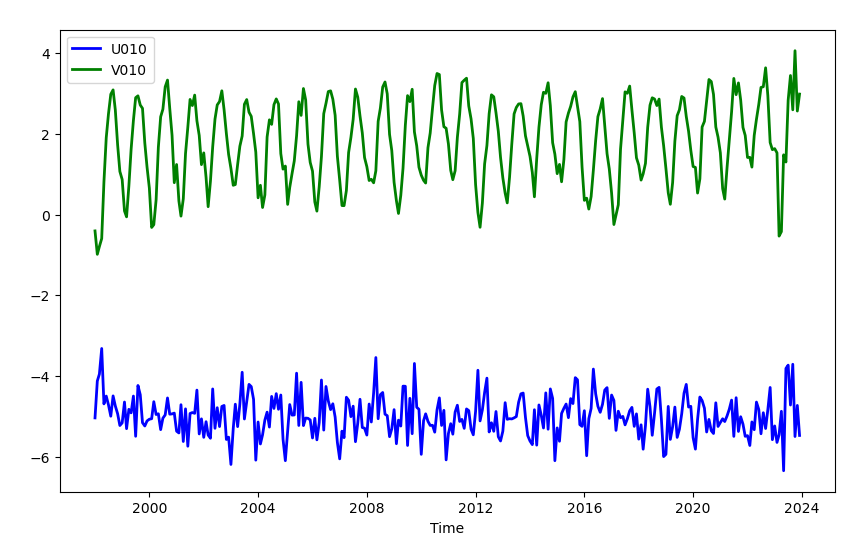

In [27]:

# #ADA

# 'year' 차원 기준으로 시계열 플롯 그리기
plt.figure(figsize=(10, 6))

# Ensemble mean: 굵은 검은 선
time_mask = (data_U010['time'].dt.year > 1997) & (data_U010['time'].dt.year < 2024)
plt.plot(data_U010['time'].isel(time=time_mask), data_U010['obs_U010'].isel(time=time_mask), color='blue', linewidth=2, label='U010')
time_mask = (data_V010['time'].dt.year > 1997) & (data_V010['time'].dt.year < 2024)
plt.plot(data_V010['time'].isel(time=time_mask), data_V010['obs_V010'].isel(time=time_mask), color='green', linewidth=2, label='V010')
# plt.plot(mean_FG_CO2_le['year'], mean_FG_CO2_le, color='green', linewidth=2, label='LE')
# plt.plot(mean_FG_CO2_wda['year'], mean_FG_CO2_wda, color='red', linewidth=2, label='WDA')
# plt.plot(fg_co2_data_obs['year'], fg_co2_data_obs, color='black', linewidth=2, label='OBS')


# 레이블과 제목
plt.xlabel('Time')
plt.ylabel(' ')
plt.title('  ')
plt.legend()

# 그래프 표시

plt.rcParams.update({'font.size': 15})

plt.show()

In [28]:
data_U010

<xarray.Dataset> Size: 14kB
Dimensions:   (time: 900)
Coordinates:
  * time      (time) datetime64[ns] 7kB 1950-01-01 1950-02-01 ... 2024-12-01
Data variables:
    obs_U010  (time) float64 7kB ...

In [29]:
#OBS GLobColour NPP :
# Long_name Multi-sensor Integrated Primary Production
# Standard_name: primary_productivity_of_biomass_expressed_as_carbon
# Units g m^-2 day^-1    

#LE NPP : mmol/m^3 cm/s (mmol/m^3 cm/s == nmol/cm^2/s)
# nmol/cm^2/s -> /8.32/10^7 *100 *100 * 86400 -> g / m^-2 / day
plt.figure(figsize=(10, 6))

# Ensemble mean: 굵은 검은 선
# time_mask = (data_NPP['time'].dt.year > 1997) & (data_NPP['time'].dt.year < 2024)
# plt.plot(data_NPP['time'].isel(time=time_mask), data_NPP['obs_photoC_TOT_zint_100m'].isel(time=time_mask), color='blue', linewidth=2, label='NPP')
time_mask = (LE_data['time'].dt.year > 1997) & (LE_data['time'].dt.year < 2024)
tmp_data = LE_data['photoC_TOT_zint_100m'].isel(ens_LE=0).where(time_mask, drop=True) / 8.32 / 10^7 * 100 * 100 * 86400
# LE_data['photoC_TOT_zint_100m']\
#       .isel(ens_LE=0)\
#       .where(time_mask, drop=True)\
#       .plot(linewidth=2, color='green', label='NPP_LE')
# tmp_data.plot(linewidth=2, color='green', label='NPP_LE')
# plt.plot(mean_FG_CO2_le['year'], mean_FG_CO2_le, color='green', linewidth=2, label='LE')
# plt.plot(mean_FG_CO2_wda['year'], mean_FG_CO2_wda, color='red', linewidth=2, label='WDA')
# plt.plot(fg_co2_data_obs['year'], fg_co2_data_obs, color='black', linewidth=2, label='OBS')


# 레이블과 제목
plt.xlabel('Time')
plt.ylabel(' ')
plt.title('  ')
plt.legend()

# 그래프 표시

plt.rcParams.update({'font.size': 15})

plt.show()

TypeError: ufunc 'bitwise_xor' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

<Figure size 1000x600 with 0 Axes>

In [ ]:
data_NPP['obs_photoC_TOT_zint_100m']

In [ ]:
LE_data['time']